For our project, we used the StackOverFlow open questionnaires. Questionnaires are presented in the form of  csv-files for each year separately from 2011 to 2019. Each year, the questionnaire is modified: some questions are added or removed, questions and possible answers also undergo changes.

The aim of the project is to analyze the questionnaires for all the years and find something interesting. :) In order to proceed to the analysis, it is necessary to carry out pre-processing, namely, to bring the questionnaires for all years (with different questions and different answer options) to to general view.

We import the necessary libraries for work.

In [1]:
import turicreate as tc
from turicreate import SFrame
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

db_path='research/'
file_names=os.listdir(db_path)

def get_schema(file):
  for i in enumerate(file.columns):
    print(i)

First, let's look at the size of our questionnaires.

In [2]:
df2011=pd.read_csv('research/2011.csv', header=0,encoding = "latin", error_bad_lines=False)
df2012=pd.read_csv('research/2012.csv', header=0,encoding = "latin", error_bad_lines=False)
df2013=pd.read_csv('research/2013.csv', header=0,encoding = "latin", error_bad_lines=False)
df2014=pd.read_csv('research/2014.csv', header=0,encoding = "latin", error_bad_lines=False)
df2015=pd.read_csv('research/2015.csv', header=0,encoding = "latin", error_bad_lines=False)
df2016=pd.read_csv('research/2016.csv', header=0,encoding = "latin", error_bad_lines=False)
df2017=pd.read_csv('research/2017.csv', header=0,encoding = "latin", error_bad_lines=False)
df2018=pd.read_csv('research/2018.csv', header=0,encoding = "latin", error_bad_lines=False)
df2019=pd.read_csv('research/2019.csv', header=0,encoding = "latin", error_bad_lines=False)
df=[df2011,df2012,df2013,df2014,df2015,df2016,df2017,df2018,df2019]
year=2011
for i in df:
  print (f'Year:{year}, Rows: {i.shape[0]}, Columns: {i.shape[1]}')
  year+=1


Year:2011, Rows: 2814, Columns: 65
Year:2012, Rows: 6244, Columns: 75
Year:2013, Rows: 9743, Columns: 128
Year:2014, Rows: 7644, Columns: 120
Year:2015, Rows: 26087, Columns: 222
Year:2016, Rows: 56030, Columns: 66
Year:2017, Rows: 51392, Columns: 154
Year:2018, Rows: 98855, Columns: 129
Year:2019, Rows: 88883, Columns: 85


The values of the columns correspond to various questions, and the rows - to the answers of the respondents. As we see, we have a huge number of questions, which necessitates careful processing.

In a detailed review of each questionnaire separately, we are faced with the fact that we need the data are located in different columns. For example, education data is scattered in different columns (as different answer options). In order to combine this data into one column, we write a function.

In [3]:
def get_info4columns(df,new_name_column,first_column,last_column=None):
  if last_column!=None:
    last_column+=1
  time_list=[]
  for row in range(len(df)):
      data=list(df.iloc[row,first_column:last_column].dropna())
      d=[]
      for i in data:
        if len(i)>1:
          d.append(i)
      time_list.append(d)    
      
  df[new_name_column]=time_list
  return df
  

We are faced with the fact that the answers variants about education varied from year to year. We need to bring all variants of answers for all years to a general form. Let's write a function.

In [4]:
def get_education4normal(x):
      s=0
      taught=0
      online=0
      education=[]
      master=0
      bac=0
      doc=0
      try:
        for i in x:
            if 'Mathematics'in i or 'Computer' in i or 'Information' in i or 'Management' in i or 'Web' in i:
              s+=1
            if  'taught' in i or 'Taught' in i:
              taught+=1
            if 'Master' in i or 'Professional' in i:
              master+=1
            if 'Bachelor' in i or 'Associate' in i or 'B.' in i:
              bac+=1
            if 'Doctoral ' in i or 'PhD' in i or 'doctoral' in i: 
              doc+=1
            if 'Online' in i or 'online' in i:
              education.append('Online class') 
              online+=1
      except:
        return x
      if s==0 and online>0:
        return 'Online class'
      if s==0 and online==0 and taught>0:
        return 'Self-taught'
      if s>0:
        if doc>=1:
          education.append('Doctor in Computer Science')
          
        if master>=1 and doc==0:
          education.append('Master in Computer Science') 
        if bac>=1 and doc==0 and master==0:
          education.append('Bachelor in Computer Science')
      if len(education)>0:   
        return ' + '.join(education)
      else:
        return None

In [5]:
def clear_list(x):
  a=[]
  for i in x:
    if ';' in i:
      i=i.split(';')
      for u in i:
        a.append(u)
    else:
      a.append(i)
  return a  


Let's create a new DataFrame with the columns we need for research. We will conduct pre-processing for each questionnaire separately and write the results to our new DataFrame.

In [6]:
df_all=pd.DataFrame({'Year': [], 'Country': [], 'Age': [],'Gender': [], 'Salary': [],'Education': [],'Skills': [],'IDE': [],})

for file in file_names:
  path=f'{db_path}{file}'
  year=file.split('.')[0]
  
  if '2015' in file:
    test=pd.read_csv(path, header=1,encoding = "latin", error_bad_lines=False)
  else:
    test=pd.read_csv(path, encoding = "latin", error_bad_lines=False)
    
    
  if '2011' in file:
    test=test.iloc[:,[0,2,45]]
    test.columns=['Country','Age','Salary']
    test['Year']=int(year)
    df_all=df_all.append(test, ignore_index = True) 
    
    
  if '2012' in file:
    test=test.iloc[:,[0,2,39]]
    test.columns=['Country','Age','Salary']
    test['Year']=int(year)
    df_all=df_all.append(test, ignore_index = True) 

    
  if '2013' in file:
    test=test.iloc[:,[0,2,100]]
    test.columns=['Country','Age','Salary']
    test['Year']=int(year)
    df_all=df_all.append(test, ignore_index = True) 

    
  if '2014' in file:
    test=test.iloc[:,[0,3,4,5,6,7,42,43,44,45,46,47,48,49,50,51,52,55,56,57,58,59,60,61,62,63,64,65,66,86]]
    test.drop([0], inplace=True)
    test=get_info4columns(test,'Skills',6,28)
    test=test.drop(test.columns[[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]],axis=1)  
    test.columns=['Country','Age','Gender','IT_Expirience','Occupation','Salary','Skills']
    test['Year']=int(year)
    df_all=df_all.append(test, ignore_index = True)    
     
      
  if '2015' in file:
    rep=[i for i in range(8,50)]
    repp=[0,1,2,4,5,106,97,101,102,103,188,189]
    repp=repp+rep
    test=test.iloc[:,repp]
    test=get_info4columns(test,'Skills',12)
    rep=[i for i in range(12,54)]
    test=test.drop(test.columns[rep],axis=1)
    test=get_info4columns(test,'educ1',6,9) 
    test=test.drop(test.columns[[6,7,8,9]],axis=1)
    test.columns=['Country','Age','Gender','IT_Expirience','Occupation','Salary','IDE','2','Skills','Education']
    test=test.drop(columns=['2'])    
    test['Year']=int(year) 
    test['Education']= test['Education'].apply(lambda x:get_education4normal(x))
    df_all=df_all.append(test, ignore_index = True)    

    
  if '2016' in file:
    repp=[2,6,7,12, 9, 14, 16, 37,28]
    test=test.iloc[:,repp]
    test.columns=['Country','Age','Gender','IT_Expirience','Occupation','Salary','Skills','Education','IDE']
    test['Year']=int(year)
    test['Skills']=test['Skills'].str.split(pat=';')
    test['Education']=test['Education'].str.split(pat=';')
    test['IDE']=test['IDE'].str.split(pat=';')
    test['Education']= test['Education'].apply(lambda x:get_education4normal(x))
    df_all=df_all.append(test, ignore_index = True)  

    
  if '2017' in file:
    repp=[3,145,6,7,83,11,14,15,16,17,152,88,90,92,96]
    test=test.iloc[:,repp]
    test=get_info4columns(test,'Education2',2,last_column=4)
    test=get_info4columns(test,'Occup',6,last_column=9)
    test=get_info4columns(test,'Skills',11,last_column=13)
    test['Skills']=test['Skills'].apply(lambda x: clear_list(x))
    test=test.drop(test.columns[[2,3,4,6,7,8,9,11,12,13]],axis=1)
    test['IDE']=test['IDE'].str.split(pat=';')
    test.columns=['Country','Gender','IT_Expirience','Salary','IDE','Education','Occupation','Skills']
    test['Year']=int(year)
    test['Education']= test['Education'].apply(lambda x:get_education4normal(x))
    df_all=df_all.append(test, ignore_index = True)  

    
  if '2018' in file:
    repp=[3,6,7,58,122,120,124,9,10,52,65,67,71,73]
    test=test.iloc[:,repp]
    test['IDE']=test['IDE'].str.split(pat=';')
    test=get_info4columns(test,'Skills',10,last_column=12)
    test['Skills']=test['Skills'].apply(lambda x: clear_list(x))
    test=test.drop(test.columns[[4,10,11,12]],axis=1) 
    test=get_info4columns(test,'Education',1,last_column=3)
    test['Education']= test['Education'].apply(lambda x:get_education4normal(x)) 
    test=test.drop(test.columns[[1,2,3]],axis=1)
    test['Occupation']=test['DevType'].str.split(pat=';')
    test=test.drop(test.columns[[3]],axis=1)
    test=test.rename(columns={"YearsCoding": "IT_Expirience"})
    test['Year']=int(year)
    df_all=df_all.append(test, ignore_index = True)    
       
      
  if '2019' in file:        
    repp=[6,8,9,10,12,13,43,45,49,51,53,77,78,31]
    test=test.iloc[:,repp]
    test['IDE']=test['DevEnviron'].str.split(pat=';')
    test=get_info4columns(test,'Skills',6,last_column=9)
    test['Skills']=test['Skills'].apply(lambda x: clear_list(x))
    test=get_info4columns(test,'Education',1,last_column=3)
    test['Education']= test['Education'].apply(lambda x:get_education4normal(x))
    test['Occupation']=test['DevType'].str.split(pat=';')
    test=test.drop(test.columns[[1,2,3,4,6,7,8,9,10]],axis=1)
    test=test.rename(columns={"YearsCode": "IT_Expirience"})
    test=test.rename(columns={"ConvertedComp": "Salary"})
    test['Year']=int(year)
    df_all=df_all.append(test, ignore_index = True) 


df_all=df_all.sort_values(by=['Year'],ascending=False)  
df_all


Age                   Country  \
347689        18                     Spain   
288437        23                  Pakistan   
288429        24                     India   
288430        42                    Canada   
288431        54                    France   
288432        35                 Argentina   
288433        62             United States   
288434        38                   Belgium   
288435       NaN                     India   
288436        24             United States   
288438        24                    Cyprus   
288427        43                    Poland   
288439        54        Russian Federation   
288440        24                    Greece   
288441        23                     Spain   
288442        24                   Germany   
288443        26               South Korea   
288444       NaN                     Italy   
288445        32                     Spain   
288446        22             United States   
288428        52                  Portugal   
288426        19                Azerbaijan   
288405        53             United States   
288415        26                  Paraguay   
288407        36                  Viet Nam   
288408        32                    Turkey   
288409        38                    Mexico   
288410        27                   Nigeria   
288411        23             United States   
288412        34        Russian Federation   
...          ...                       ...   
1856       35-39            United Kingdom   
1855       30-34            United Kingdom   
1854       20-24                 Australia   
1853       25-29               Australasia   
1852       35-39                 Australia   
1851       40-50  United States of America   
1850       25-29                 Australia   
1868       35-39  United States of America   
1870       30-34  United States of America   
1890       35-39               Netherlands   
1881         NaN                   Germany   
1889       40-50               Australasia   
1888        < 20             South America   
1887       35-39  United States of America   
1886       30-34            United Kingdom   
1885       30-34               Australasia   
1884       30-34                 Australia   
1883       40-50              Other Europe   
1882       20-24  United States of America   
1880       40-50                 Australia   
1871       20-24  United States of America   
1879       25-29  United States of America   
1878       30-34  United States of America   
1877       35-39               Australasia   
1876       20-24              Other Europe   
1875       25-29  United States of America   
1874       25-29  United States of America   
1873       30-34                 Australia   
1872       35-39  United States of America   
0       Response                  Response   

                                          Education     Gender  \
347689    Online class + Master in Computer Science        Man   
288437                 Bachelor in Computer Science  Woman;Man   
288429                 Bachelor in Computer Science        Man   
288430                 Bachelor in Computer Science        Man   
288431                                         None        Man   
288432    Online class + Master in Computer Science        Man   
288433                 Bachelor in Computer Science        Man   
288434                                  Self-taught        Man   
288435  Online class + Bachelor in Computer Science        Man   
288436  Online class + Bachelor in Computer Science        Man   
288438                                 Online class        Man   
288427                                 Online class        Man   
288439                                  Self-taught        Man   
288440                                 Online class      Woman   
288441  Online class + Bachelor in Computer Science        Man   
288442                 Bachelor in Computer Science        Man   
288443                 Bachelor in Com

After receiving a single DataFrame, we still need to bring the values of each column to a general form. As we have done above with the education column. Let's start with the age.

In [7]:
def age_category(x):
  if x==None:
    return None
  if '20' in x:
    return 'young <25'
  else:
    return ' old >25'


def age_rank(x):
  a='< 20'
  y='20 - 24'
  z='25 - 34'
  r='35 - 44'
  o='45 - 60'
  q='> 60'
  
  if '18 - 24 years old' in str(x):
    return y
  
  if '-' in str(x):
    x=x.split('-')[0]
    x=x.strip()
    

  try:
    x=int(x)
    if x<20:
      return a
    if 20<=x<=24:
      return y
    if 25<=x<=34:
      return z
    if 35<=x<=44:
      return r
    if 45<=x<=60:
      return o
    if x>60:
      return q
    
  except:
    
    if '65 years or older' in str(x) or '>' in str(x):
      return q
  
    if '<' in str(x) or 'Under 18 years old' in str(x):
      return a
  
    else:
      return None
  
df_all['Age_range'] = df_all['Age'].apply(lambda x: age_rank(x))
df_all['Age_category'] = df_all['Age_range'].apply(lambda x: age_category(x))

df_all['Age_range'].unique()


  
      

array(['< 20', '20 - 24', '35 - 44', '45 - 60', '> 60', None, '25 - 34'],
      dtype=object)

Let's put the countries in order.

In [8]:
def clean_country(country):
  try:
    if country =='United States':
      return 'United States of America'
    if 'Ireland' in country :
      return 'Ireland'
    if country =='Other (please specify)':
      return 'Other'
    if country =='Korea South':
      return 'South Korea'
    if country =='Republic of Korea':
      return 'South Korea'
    
    if country =='Viet Nam':
      return 'Vietnam'
    if country =='Australasia':
      return 'Australia'
    if 'Congo' in country:
      return 'Congo'

    if 'Hong Kong' in country:
      return 'Hong Kong'
    if 'Iran' in country:
      return 'Iran'
    if 'Russia' in country:
      return 'Russian Federation'
    else:
      return country
  except:
    return None


df_all['Country']=df_all['Country'].apply(lambda x:clean_country(x) )



Let's put the salaries in order.

In [9]:
def get_range_salary(salary,mid=0):
  if '-' in str(salary):
    salary=str(salary).split('-')[0]
  if '$' in str(salary):
    salary=str(salary).split('$')[1] 
  if ',' in str(salary):
    salary=str(salary).replace(',','')
  
  if mid==0:
    a='0'
    b='<20.000'
    c='$20.000 - $40.000'
    d='$40.000 - $60.000'
    e='$60.000 - $80.000'
    f='$80.000 - $100.000'
    j='$100.000 - $120.000'
    h='$120.000 - $140.000'
    i='>$140.000'
  
  if mid==1:
    a=0
    b=10000
    c=30000
    d=50000
    e=70000
    f=90000
    j=110000
    h=130000
    i=150000
  
  try:
      salary=float(salary)
      if (salary)==0:
        return a
      if (salary)<20000:
        return b
      if 20000<=(salary)<40000:
        return c
      if 40000<=(salary)<60000:
        return d
      if 60000<=(salary)<80000:
        return e
      if 80000<=(salary)<100000:
        return f
      if 100000<=(salary)<120000:
        return j
      if 120000<=(salary)<140000:
        return h
      if 140000<=(salary):
        return i
  except ValueError:
    
      if 'Student ' in str(salary):
        return a
      else:
        return None    


df_all['Salary Range']=df_all['Salary'].apply(lambda x:get_range_salary(x))
df_all['Salary Midpoint']=df_all['Salary'].apply(lambda x:get_range_salary(x,1))

df_all['Salary Range'].unique()

array([None, '$120.000 - $140.000', '<20.000', '$60.000 - $80.000',
       '$80.000 - $100.000', '$20.000 - $40.000', '$40.000 - $60.000',
       '>$140.000', '$100.000 - $120.000', '0'], dtype=object)

We perform a similar operation, which was above, on the Occupation column.

In [10]:
def get_occupation(x):
  if isinstance(x,list):
    try:
      a= ",".join(x)
    except:
       a= None
  else:
    a= x
    
    
  if 'ata scientist' in str(a) or 'Machine' in str(a) or 'nalyst'  in str(a) or 'intelligence'  in str(a):
    return 'Data scientist or machine learning specialist'    
  elif 'ack-end' in str(a) or 'Back-End' in str(a): 
      return 'Back-end Developer'
  elif 'ront-end' in str(a) or 'Front-End' in str(a) or 'raphics' in str(a):
      return 'Front-end Developer' 
  elif 'ull-stack' in str(a) or 'Full' in str(a) or 'Web developer' in str(a):
      return 'Full-stack Developer'   
  elif 'obile' in str(a):
      return 'Mobile Developer' 
  elif 'DevOps' in str(a):
      return 'DevOps'     
  elif 'esktop' in str(a) or 'pplication' in str(a) or 'Enterprise' in str(a): 
      return 'Desktop application developer'   
  elif 'atabase' in str(a) or 'Engineer' in str(a):
      return 'Database administrator' 
  elif 'dministrator' in str(a):
      return 'Systems administrator' 
  elif 'anager' in str(a) or 'xecutive' in str(a) or 'sales' in str(a):
      return 'Manager of Developers or Team Leader'  
  elif 'Quality' in str(a) or 'QA' in str(a):
     return 'Quality assurance engineer' 
  elif 'eveloper' in str(a):
     return 'Full-stack Developer'  
  elif 'esigner' in str(a):
     return 'Designer' 
  elif 'cademic' in str(a) or 'cientist' in str(a) or 'Educator' in str(a):
     return 'Academic researcher'   
  elif 'Student' in str(a):
     return 'Student'   
 
  else:
    return "Other"
  
df_all['Occupation']=df_all['Occupation'].apply(lambda x:get_occupation(x))
df_all['Occupation'].unique()

    

array(['Other', 'Full-stack Developer', 'Back-end Developer',
       'Front-end Developer',
       'Data scientist or machine learning specialist',
       'Academic researcher', 'Systems administrator',
       'Database administrator', 'Manager of Developers or Team Leader',
       'Mobile Developer', 'Student', 'Desktop application developer',
       'Designer', 'Quality assurance engineer', 'DevOps'], dtype=object)

Now it's the Gender column turn.

In [11]:
def clear_gender(x):
    x=str(x)
    if ';' in x:
      x=x.split(';')[0]
    x=x.strip()
    if 'Man' in x:
      x='Male'
    if 'Woman' in x:
      x='Female'
    if 'non-conforming' in x:
      x='Other'
    if 'nan' in x:
      x='Prefer not to disclose'
    return x 

df_all['Gender']=df_all['Gender'].apply(lambda x:clear_gender(x))
df_all['Gender'].unique()



array(['Male', 'Female', 'Other', 'Prefer not to disclose', 'Transgender'],
      dtype=object)

Finally, let's process the experience column.

In [12]:
def expirience_range(expirience):
  a = '0-2'
  b = '3-5'
  c = '6-10'
  d = '11+'
  expirience=str(expirience)
  expirience=expirience.split('to')[0].strip()
  if '2 - 5 years' in expirience:
    return b
  if 'Less' in expirience or '<' in expirience:
    return a
  if 'ore' in expirience or '+' in expirience:  
     return d
  if '6/10/2014' in expirience :  
     return c
  if '2/5/2014' in expirience:  
     return b
  expirience=expirience.split('-')[0].strip()
  x = float(expirience)
  if x<3:
    return a
  if 3<=x<=5:
    return b
  if 6<=x<=10:
    return c
  if x>=11:
    return d
  else:
    return None
   
  
df_all['IT_Expirience']=df_all['IT_Expirience'].apply(lambda expirience:expirience_range(expirience))

df_all['IT_Expirience'].unique()

array(['6-10', '3-5', '11+', '0-2', None], dtype=object)

In [13]:
df_all

Age                   Country  \
347689        18                     Spain   
288437        23                  Pakistan   
288429        24                     India   
288430        42                    Canada   
288431        54                    France   
288432        35                 Argentina   
288433        62  United States of America   
288434        38                   Belgium   
288435       NaN                     India   
288436        24  United States of America   
288438        24                    Cyprus   
288427        43                    Poland   
288439        54        Russian Federation   
288440        24                    Greece   
288441        23                     Spain   
288442        24                   Germany   
288443        26               South Korea   
288444       NaN                     Italy   
288445        32                     Spain   
288446        22  United States of America   
288428        52                  Portugal   
288426        19                Azerbaijan   
288405        53  United States of America   
288415        26                  Paraguay   
288407        36                   Vietnam   
288408        32                    Turkey   
288409        38                    Mexico   
288410        27                   Nigeria   
288411        23  United States of America   
288412        34        Russian Federation   
...          ...                       ...   
1856       35-39            United Kingdom   
1855       30-34            United Kingdom   
1854       20-24                 Australia   
1853       25-29                 Australia   
1852       35-39                 Australia   
1851       40-50  United States of America   
1850       25-29                 Australia   
1868       35-39  United States of America   
1870       30-34  United States of America   
1890       35-39               Netherlands   
1881         NaN                   Germany   
1889       40-50                 Australia   
1888        < 20             South America   
1887       35-39  United States of America   
1886       30-34            United Kingdom   
1885       30-34                 Australia   
1884       30-34                 Australia   
1883       40-50              Other Europe   
1882       20-24  United States of America   
1880       40-50                 Australia   
1871       20-24  United States of America   
1879       25-29  United States of America   
1878       30-34  United States of America   
1877       35-39                 Australia   
1876       20-24              Other Europe   
1875       25-29  United States of America   
1874       25-29  United States of America   
1873       30-34                 Australia   
1872       35-39  United States of America   
0       Response                  Response   

                                          Education                  Gender  \
347689    Online class + Master in Computer Science                    Male   
288437                 Bachelor in Computer Science                  Female   
288429                 Bachelor in Computer Science                    Male   
288430                 Bachelor in Computer Science                    Male   
288431                                         None                    Male   
288432    Online class + Master in Computer Science                    Male   
288433                 Bachelor in Computer Science                    Male   
288434                                  Self-taught                    Male   
288435  Online class + Bachelor in Computer Science                    Male   
288436  Online class + Bachelor in Computer Science                    Male   
288438                                 Online class                    Male   
288427                                 Online class                    Male   
288439                                  Self-taught                    Male   
288440                                 Online class   

Now we have a DataFrame suitable for further analysis.

Text(0, 0.5, 'Count')

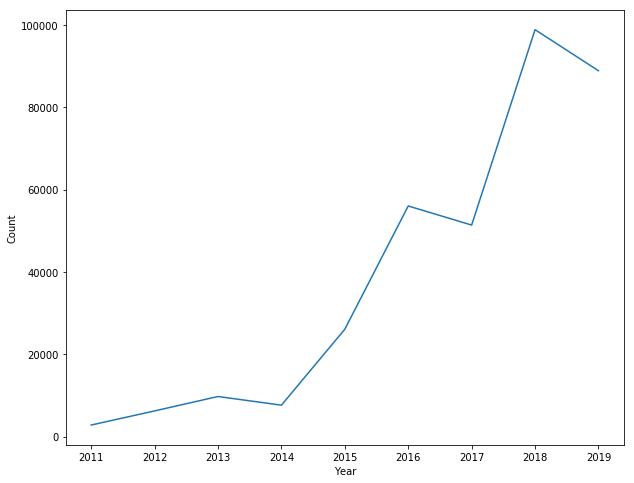

In [14]:
graf_count_year=df_all.groupby(['Year']).size().reset_index(name='counts')
plt.figure(figsize = (10, 8), facecolor = None) 
ax = sns.lineplot(x='Year', y='counts', data=graf_count_year)
plt.xlabel("Year")
plt.ylabel("Count")

From the graph we see that after 2014 the number of participants begins to grow every year more and more.

Text(0, 0.5, 'Count')

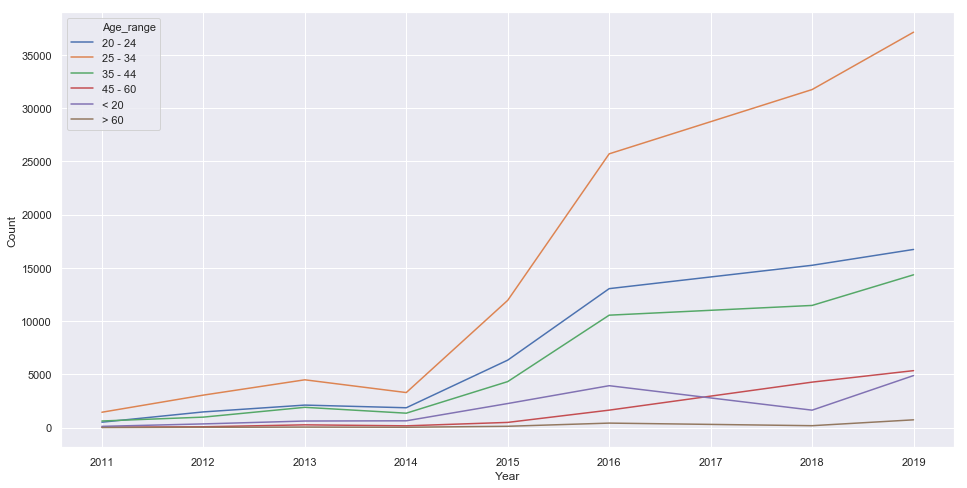

In [15]:
graf_count_age=df_all.groupby(['Year','Age_range']).size().reset_index(name='counts')
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 

ax = sns.lineplot(x="Year", y="counts", hue="Age_range", data=graf_count_age)
plt.xlabel("Year")
plt.ylabel("Count")

After analyzing the graph of age ranks, we also see that all changes begin to occur after 2014. In the future, it will be logical to carefully consider only the years from 2014 to 2019.
It can also be seen that the main number of specialists falls on the age from 20 to 45. The most actively growing specialist category  is from 20 to 25 years.


Text(0, 0.5, 'Count')

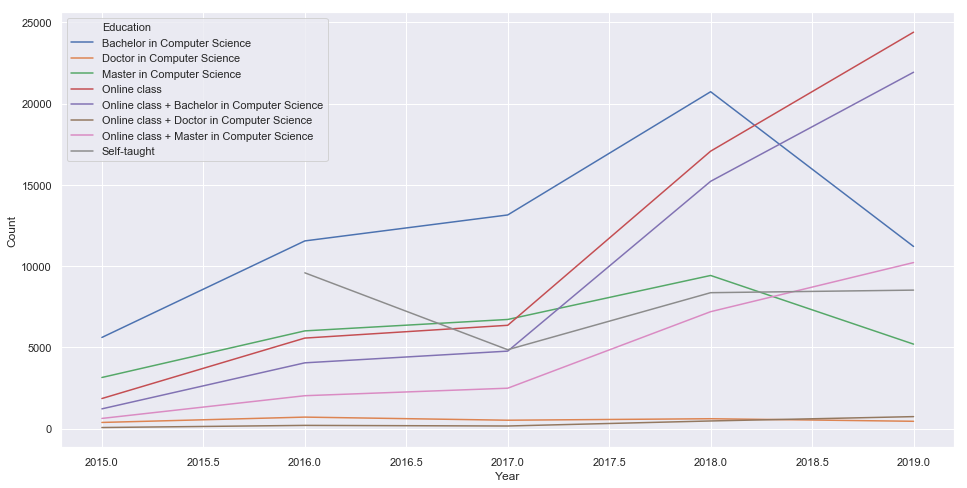

In [16]:
graf_count_educ=df_all.groupby(['Year','Education']).size().reset_index(name='counts')
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 

ax = sns.lineplot(x="Year", y="counts", hue="Education", data=graf_count_educ)
plt.xlabel("Year")
plt.ylabel("Count")

From this graph, we see that the largest number of specialists has a bachelor's degree. Since 2017, the number of specialists who have received online education has begun to grow, and to date, this type of education has been very popular. Perhaps this is due to the growth of high-quality online resources. For example, Coursera presents courses from prestigious higher education institutions from around the world in different languages.
It can also be noted that the number of specialists with a doctoral education is a very low part for the entire time, which is quite logical.


Text(0, 0.5, 'Salary Average')

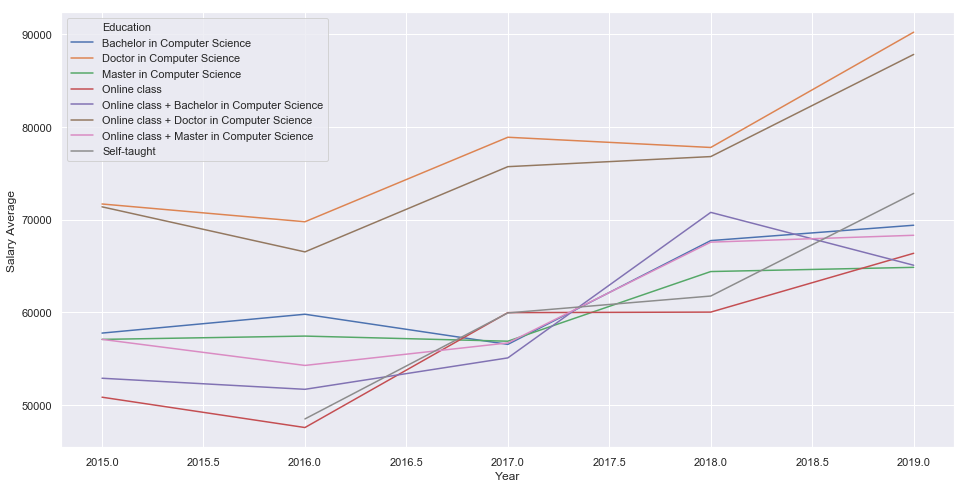

In [17]:
graf_salary_educ=df_all.groupby(['Year','Education'], as_index=False)['Salary Midpoint'].mean()
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 

ax = sns.lineplot(x="Year", y="Salary Midpoint", hue="Education", data=graf_salary_educ)
plt.xlabel("Year")
plt.ylabel("Salary Average")

From the graph of the dependence of education on average wages, we see that the highest wages belong to the PhDs, and there is a significant difference compared to the other categories. They are followed by bachelors, but in recent years we have seen an increase in salaries for self-taught people and online classes. In 2019, their salaries compete with bachelor's salaries. What is quite an interesting phenomenon.

Text(0, 0.5, 'Count')

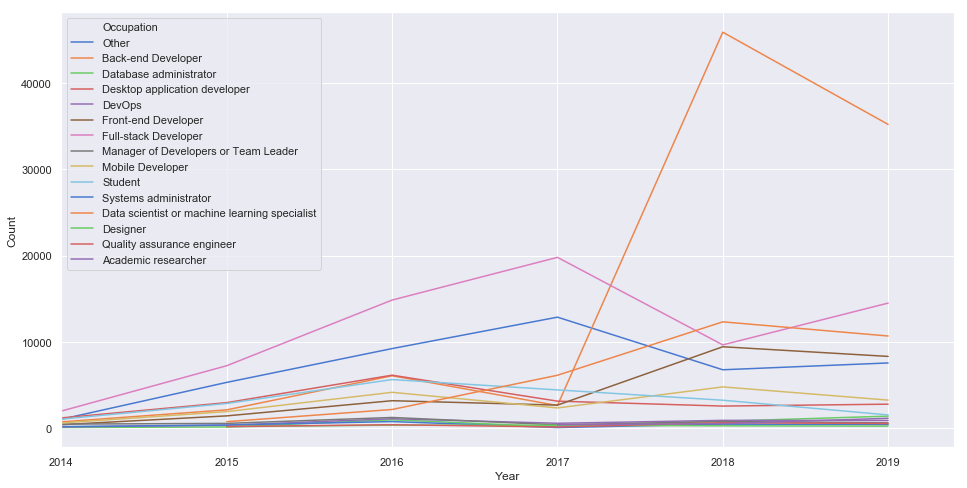

In [18]:
graf_count_ocup=df_all.groupby(['Year','Occupation']).size().reset_index(name='counts')
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 

ax = sns.lineplot(x="Year", y="counts", hue="Occupation",palette='muted' ,data=graf_count_ocup)
plt.xlabel("Year")
plt.xlim(2014)
plt.ylabel("Count")

Consider the number of employees in different positions. It is interesting to note that we see a sharp increase among the back-end developers, followed by the category of full-stack developers (which is obvious, as these are two very close positions). All other posts are moderately distributed over the years. Perhaps this is due to salaries in this area. Now we will check it.

(2014, 2019.4)

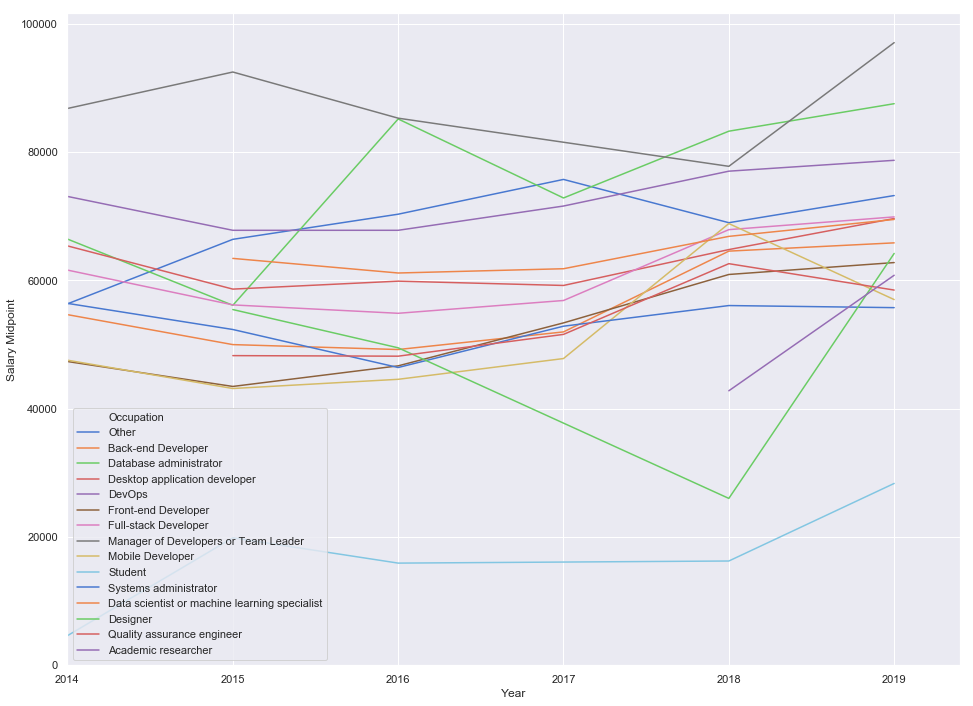

In [19]:
df_occup_salary=df_all.groupby(['Year','Occupation'], as_index=False)['Salary Midpoint'].mean()
sns.set()
plt.figure(figsize = (16, 12), facecolor = None) 

ax = sns.lineplot(x="Year", y="Salary Midpoint", hue="Occupation",palette='muted' ,data=df_occup_salary)
plt.xlabel("Year")
plt.ylabel("Salary Midpoint")
plt.xlim(2014)

From the graph, we see that the leaders of the teams earn the most. In recent years, database administrators have been catching up with them (perhaps they are Data Scientists). Devops are also among the well-paid professionals. After them, the salaries of full-stack and back-end developers, as we see, these are not the highest paying positions.



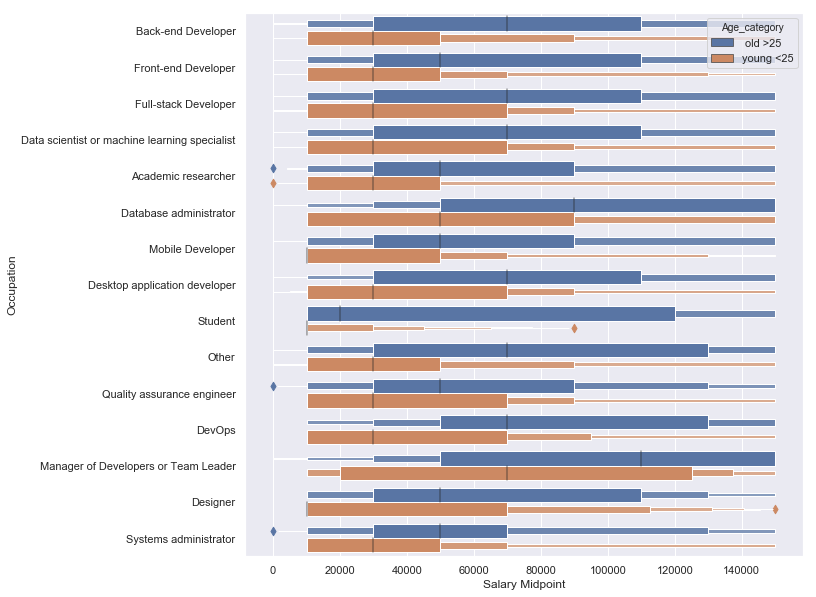

In [20]:
df_occup_salary=df_all[df_all['Year']==2019]
df_occup_salary=df_occup_salary[['Occupation','Salary Midpoint','Age_category']].dropna()
fig, ax =plt.subplots(figsize=(10,10))
sns.boxenplot(y="Occupation", x="Salary Midpoint", hue="Age_category",
               data=df_occup_salary)

In all positions, young professionals earn less. This situation is better only on the positions of team leaders and database administrators (As pointed out above, data scientists).

Let's try to consider the occupation in terms of education.

In [21]:
def get_educ(x):
  try:
    if 'Master' in x:
      return 'Master in Computer Science'
    elif 'Doctor' in x:
      return 'Doctor in Computer Science'
    elif 'Bachelor ' in x:
      return 'Bachelor in Computer Science'
    elif 'Other' in x or 'Online' in x or 'Self' in x:
      return 'Not Educated'
  except:
    return None

df_occup_educ=df_all.copy()  
df_occup_educ['Education']=df_occup_educ['Education'].apply(lambda x:get_educ(x))
df_occup_educ=df_occup_educ.groupby(['Education','Occupation']).size().reset_index(name='counts')
df_occup_educ


Education  \
0   Bachelor in Computer Science   
1   Bachelor in Computer Science   
2   Bachelor in Computer Science   
3   Bachelor in Computer Science   
4   Bachelor in Computer Science   
5   Bachelor in Computer Science   
6   Bachelor in Computer Science   
7   Bachelor in Computer Science   
8   Bachelor in Computer Science   
9   Bachelor in Computer Science   
10  Bachelor in Computer Science   
11  Bachelor in Computer Science   
12  Bachelor in Computer Science   
13  Bachelor in Computer Science   
14  Bachelor in Computer Science   
15    Doctor in Computer Science   
16    Doctor in Computer Science   
17    Doctor in Computer Science   
18    Doctor in Computer Science   
19    Doctor in Computer Science   
20    Doctor in Computer Science   
21    Doctor in Computer Science   
22    Doctor in Computer Science   
23    Doctor in Computer Science   
24    Doctor in Computer Science   
25    Doctor in Computer Science   
26    Doctor in Computer Science   
27    Doctor in Computer Science   
28    Doctor in Computer Science   
29    Doctor in Computer Science   
30    Master in Computer Science   
31    Master in Computer Science   
32    Master in Computer Science   
33    Master in Computer Science   
34    Master in Computer Science   
35    Master in Computer Science   
36    Master in Computer Science   
37    Master in Computer Science   
38    Master in Computer Science   
39    Master in Computer Science   
40    Master in Computer Science   
41    Master in Computer Science   
42    Master in Computer Science   
43    Master in Computer Science   
44    Master in Computer Science   
45                  Not Educated   
46                  Not Educated   
47                  Not Educated   
48                  Not Educated   
49                  Not Educated   
50                  Not Educated   
51                  Not Educated   
52                  Not Educated   
53                  Not Educated   
54                  Not Educated   
55                  Not Educated   
56                  Not Educated   
57                  Not Educated   
58                  Not Educated   
59                  Not Educated   

                                       Occupation  counts  
0                             Academic researcher     236  
1                              Back-end Developer   38399  
2   Data scientist or machine learning specialist    9424  
3                          Database administrator    1009  
4                                        Designer     257  
5                   Desktop application developer    6108  
6                                          DevOps    1330  
7                             Front-end Developer    8640  
8                            Full-stack Developer   26459  
9            Manager of Developers or Team Leader     898  
10                               Mobile Developer    6728  
11                                          Other    5774  
12                     Quality assurance engineer     610  
13                                        Student    3036  
14                          Systems administrator     522  
15                            Academic researcher     231  
16                             Back-end Developer     763  
17  Data scientist or machine learning specialist    1326  
18                         Database administrator      67  
19                                       Designer      15  
20                  Desktop application developer     331  
21                                         DevOps      42  
22                            Front-end Developer     142  
23                           Full-stack Developer     658  
24           Manager of Developers or Team Leader     111  
25                               Mobile Developer     115  
26                                          Other     410  
27                     Quality assurance engineer      16  
28                                        Student     116  
29                        

In [22]:
df_occup_educ=df_occup_educ.pivot(index='Education', columns='Occupation', values='counts')
df_occup_educ

Occupation                    Academic researcher  Back-end Developer  \
Education                                                               
Bachelor in Computer Science                  236               38399   
Doctor in Computer Science                    231                 763   
Master in Computer Science                    349               17334   
Not Educated                                  942               24514   

Occupation                    Data scientist or machine learning specialist  \
Education                                                                     
Bachelor in Computer Science                                           9424   
Doctor in Computer Science                                             1326   
Master in Computer Science                                             6746   
Not Educated                                                          10429   

Occupation                    Database administrator  Designer  \
Education                                                        
Bachelor in Computer Science                    1009       257   
Doctor in Computer Science                        67        15   
Master in Computer Science                       672       107   
Not Educated                                    1014       443   

Occupation                    Desktop application developer  DevOps  \
Education                                                             
Bachelor in Computer Science                           6108    1330   
Doctor in Computer Science                              331      42   
Master in Computer Science                             3909     726   
Not Educated                                           3766     993   

Occupation                    Front-end Developer  Full-stack Developer  \
Education                                                                 
Bachelor in Computer Science                 8640                 26459   
Doctor in Computer Science                    142                   658   
Master in Computer Science                   3335                 11852   
Not Educated                                 8473                 15812   

Occupation                    Manager of Developers or Team Leader  \
Education                                                            
Bachelor in Computer Science                                   898   
Doctor in Computer Science                                     111   
Master in Computer Science                                     654   
Not Educated                                                  1069   

Occupation                    Mobile Developer  Other  \
Education                                               
Bachelor in Computer Science              6728   5774   
Doctor in Computer Science                 115    410   
Master in Computer Science                3397   2698   
Not Educated                              3300   9807   

Occupation                    Quality assurance engineer  Student  \
Education                                                           
Bachelor in Computer Science                         610     3036   
Doctor in Computer Science                            16      116   
Master in Computer Science                           282      816   
Not Educated                                         545     4838   

Occupation                    Systems administrator  
Education                                            
Bachelor in Computer Science                    522  
Doctor in Computer Science                       17  
Master in Computer Science                      209  
Not Educated                                    641

In [23]:
a1=df_occup_educ.values[0]
a2=df_occup_educ.values[1]
a3=df_occup_educ.values[2]
a4=df_occup_educ.values[3]
a=list(zip(a1, a2, a3,a4))
b=df_occup_educ.columns
results=dict(zip(b,a))
results

{'Academic researcher': (236, 231, 349, 942),
 'Back-end Developer': (38399, 763, 17334, 24514),
 'Data scientist or machine learning specialist': (9424, 1326, 6746, 10429),
 'Database administrator': (1009, 67, 672, 1014),
 'Designer': (257, 15, 107, 443),
 'Desktop application developer': (6108, 331, 3909, 3766),
 'DevOps': (1330, 42, 726, 993),
 'Front-end Developer': (8640, 142, 3335, 8473),
 'Full-stack Developer': (26459, 658, 11852, 15812),
 'Manager of Developers or Team Leader': (898, 111, 654, 1069),
 'Mobile Developer': (6728, 115, 3397, 3300),
 'Other': (5774, 410, 2698, 9807),
 'Quality assurance engineer': (610, 16, 282, 545),
 'Student': (3036, 116, 816, 4838),
 'Systems administrator': (522, 17, 209, 641)}

(<Figure size 1080x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x218b0d604e0>)

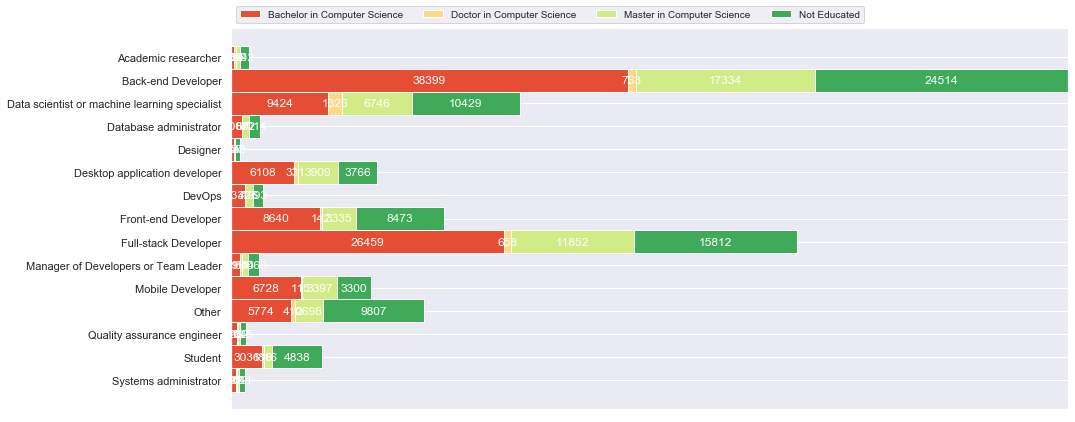

In [24]:
category_names = ['Bachelor in Computer Science', 'Doctor in Computer Science',
                  'Master in Computer Science', 'Not Educated']


def survey(results, category_names):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        widths=widths
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=1,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)

From the graph, we see that about 30% of specialists from the back-end and full-stack areas work without education. We also see that in Hi-Tech we can meet people without education in a sufficiently large number.

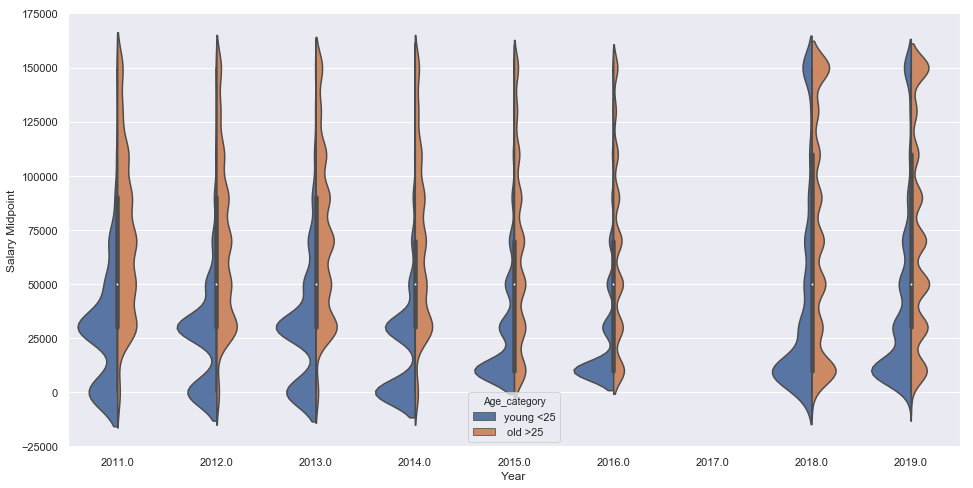

In [25]:
plt.figure(figsize = (16, 8), facecolor = None) 
sns.violinplot(x='Year', y='Salary Midpoint',hue='Age_category',split=True,data=df_all)

We observe that in recent years, young professionals more and more achieve success and receive the highest salaries in IT. Although in the past years in this category there were only older representatives.

Let's make a rating of the countries with the highest salaries.

In [26]:
df_all=df_all[df_all['Year']>2013]  
df_country=df_all.groupby(['Year','Country'], as_index=False).agg({'Salary Midpoint': ['mean','size']})
df_country.columns=list(map(' '.join,df_country.columns.values))
df_country=df_country[df_country['Salary Midpoint size']>30]
df_country=df_country.dropna()
df_country.sort_values(by=['Salary Midpoint size'],ascending=False)
df_country.columns=['Year','Country','Salary_mean','People_count']
df_country

Year                                    Country    Salary_mean  \
1    2014.0                                  Argentina   43846.153846   
3    2014.0                                  Australia   65000.000000   
4    2014.0                                    Austria   40425.531915   
7    2014.0                                    Belgium   40444.444444   
10   2014.0                                     Brazil   32906.976744   
11   2014.0                                   Bulgaria   35217.391304   
13   2014.0                                     Canada   55991.379310   
15   2014.0                                      China   30555.555556   
20   2014.0                             Czech Republic   25862.068966   
21   2014.0                                    Denmark   67708.333333   
27   2014.0                                    Finland   36285.714286   
28   2014.0                                     France   43176.470588   
30   2014.0                                    Germany   47811.550152   
32   2014.0                                     Greece   16000.000000   
35   2014.0                                    Hungary   21304.347826   
37   2014.0                                      India   27726.465364   
39   2014.0                                       Iran   20000.000000   
40   2014.0                                    Ireland   55750.000000   
41   2014.0                                     Israel   55822.784810   
42   2014.0                                      Italy   25979.381443   
55   2014.0                                     Mexico   28148.148148   
60   2014.0                                Netherlands   38720.000000   
61   2014.0                                New Zealand   62941.176471   
63   2014.0                                     Norway   68000.000000   
65   2014.0                                   Pakistan   21000.000000   
69   2014.0                                     Poland   25632.183908   
72   2014.0                                    Romania   23658.536585   
73   2014.0                         Russian Federation   33157.894737   
76   2014.0                                  Singapore   33870.967742   
79   2014.0                               South Africa   33225.806452   
..      ...                                        ...            ...   
937  2019.0                                    Romania   38120.481928   
938  2019.0                         Russian Federation   27531.645570   
944  2019.0                               Saudi Arabia   47551.020408   
946  2019.0                                     Serbia   32090.909091   
949  2019.0                                  Singapore   68589.743590   
950  2019.0                                   Slovakia   37600.000000   
951  2019.0                                   Slovenia   43137.254902   
953  2019.0                               South Africa   47057.416268   
954  2019.0                                South Korea   55862.068966   
955  2019.0                                      Spain   53397.328881   
956  2019.0                                  Sri Lanka   15090.909091   
957  2019.0                                      Sudan   11666.666667   
959  2019.0                                     Sweden   60981.256891   
960  2019.0                                Switzerland   95133.928571   
962  2019.0                                     Taiwan   33518.518519   
964  2019.0                                   Thailand   43980.582524   
965  2019.0  The former Yugoslav Republic of Macedonia   30645.161290   
970  2019.0                                    Tunisia   12777.777778   
971  2019.0                                     Turkey   21510.934394   
973  2019.0                                     Uganda   15882.352941   
974  2019.0                                    Ukraine   30405.904059   
975  2019.0                       United Arab Emirates   52272.727273   
976  2019.0                             United Kingdom   80820.52

In [27]:
px.choropleth(df_country, locations='Country', locationmode='country names',animation_frame="Year", color='Salary_mean')

We will display the countries on the map and color them according to the salaries.

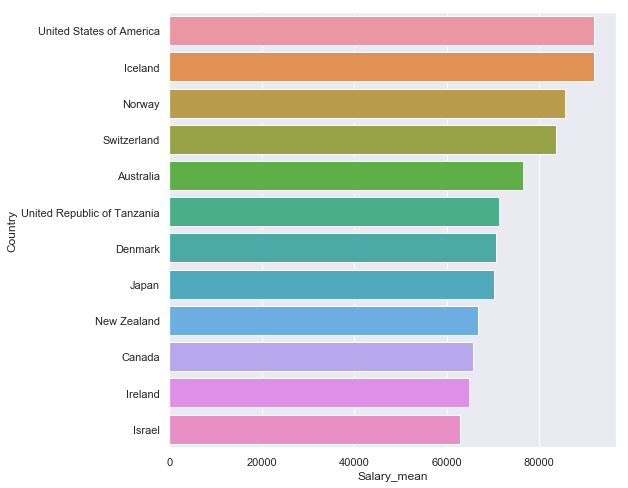

In [28]:
df_country_top=df_country.groupby(['Country'], as_index=False)['Salary_mean'].mean()
df_country_top=df_country_top.sort_values(by=['Salary_mean'],ascending=False)
top12=df_country_top['Country'].array[:12]
df_filter = df_country['Country'].isin(top12)
df_top12=df_country[df_filter]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='Country', x='Salary_mean',orient="h", data=df_country_top[:12], ax=ax)

We received the top 12 high-salary countries, and we see that Israel is on this list.

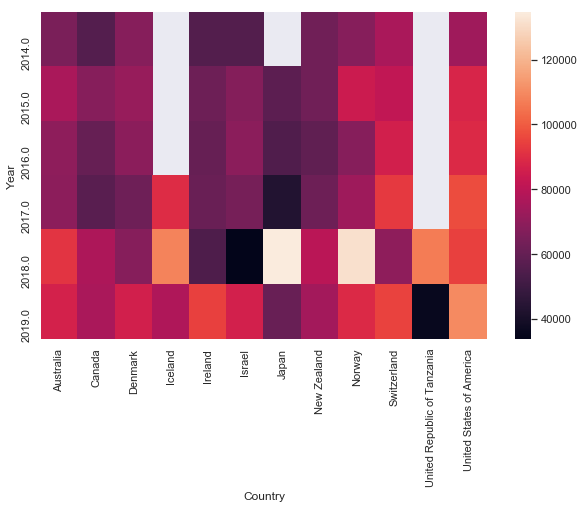

In [29]:
df_top12=df_top12[['Year','Country','Salary_mean']]
df_top12=df_top12.pivot(index='Year', columns='Country', values='Salary_mean') 

f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_top12, ax=ax)

Now consider how the dependence of the average value of wages throughout the world on the floor. As we see, until 2017, women earned less than men. However, since 2017, this gap has disappeared, which is good news.

Text(0, 0.5, 'Salary Midpoint')

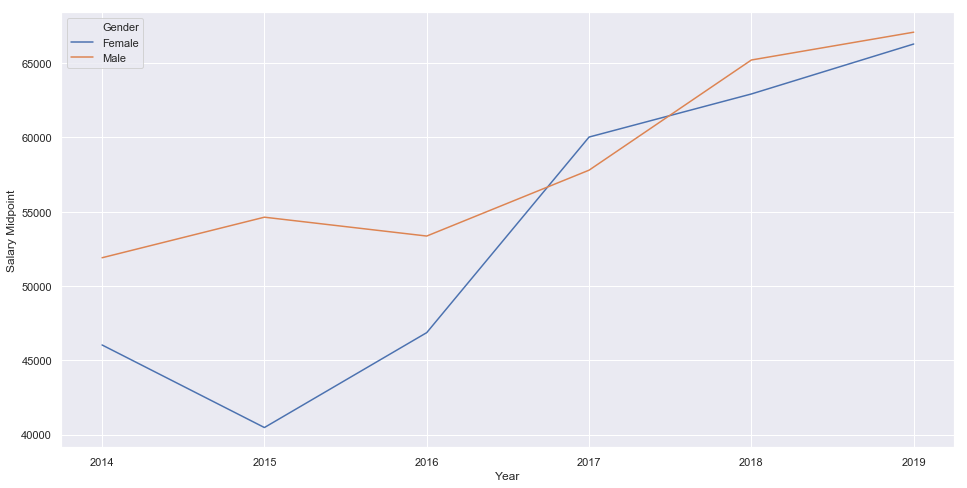

In [30]:
df_gender=df_all.query('Gender== "Male" or Gender=="Female"')
df_gender_salary=df_gender.groupby(['Year','Gender'], as_index=False)['Salary Midpoint'].mean()
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 

ax = sns.lineplot(x="Year", y="Salary Midpoint", hue="Gender", data=df_gender_salary)
plt.xlabel("Year")
plt.ylabel("Salary Midpoint")

Consider the distribution of men and women in the last year by occupation.

In [31]:
df_occup_gender=df_all.groupby(['Year','Occupation','Gender']).size().reset_index(name='Counts')
df_occup_gender=df_occup_gender.query('(Gender== "Male" or Gender=="Female") and (Year==2019)')
df_occup_gender


Year                                     Occupation  Gender  Counts
278  2019.0                            Academic researcher  Female     130
279  2019.0                            Academic researcher    Male     919
282  2019.0                             Back-end Developer  Female    1991
283  2019.0                             Back-end Developer    Male   32002
286  2019.0  Data scientist or machine learning specialist  Female     851
287  2019.0  Data scientist or machine learning specialist    Male    9387
290  2019.0                         Database administrator  Female     109
291  2019.0                         Database administrator    Male    1207
294  2019.0                                       Designer  Female      35
295  2019.0                                       Designer    Male     160
298  2019.0                  Desktop application developer  Female     183
299  2019.0                  Desktop application developer    Male    2468
302  2019.0                                         DevOps  Female      58
303  2019.0                                         DevOps    Male     784
306  2019.0                            Front-end Developer  Female    1103
307  2019.0                            Front-end Developer    Male    6905
310  2019.0                           Full-stack Developer  Female    1044
311  2019.0                           Full-stack Developer    Male   12932
314  2019.0           Manager of Developers or Team Leader  Female      70
315  2019.0           Manager of Developers or Team Leader    Male     503
318  2019.0                               Mobile Developer  Female     281
319  2019.0                               Mobile Developer    Male    2844
322  2019.0                                          Other  Female     584
323  2019.0                                          Other    Male    5949
326  2019.0                     Quality assurance engineer  Female      78
327  2019.0                     Quality assurance engineer    Male     423
330  2019.0                                        Student  Female     170
331  2019.0                                        Student    Male    1258
334  2019.0                          Systems administrator  Female      22
335  2019.0                          Systems administrator    Male     359

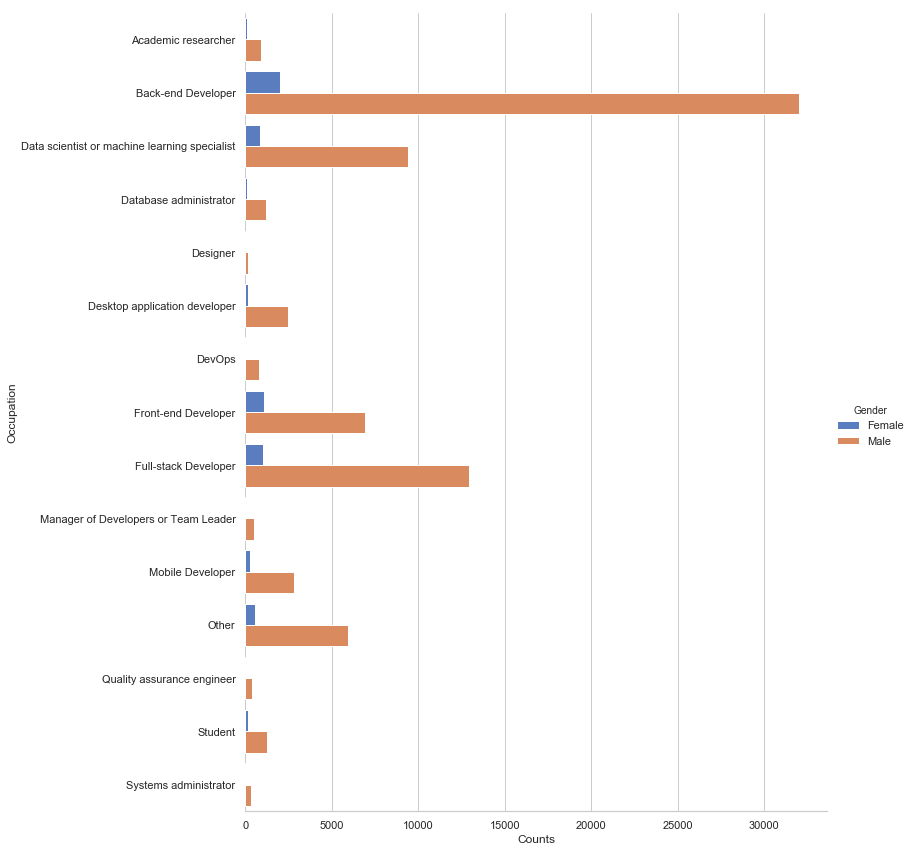

In [32]:
sns.set(style="whitegrid")
g = sns.catplot(x="Counts", y="Occupation", hue="Gender", data=df_occup_gender,                height=12, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Occupation")

We see that in all areas of women at times less than men. In front-end team and academic-research groups, women are met more often than in other areas. On the contrary, as a rule, team leaders are always men.

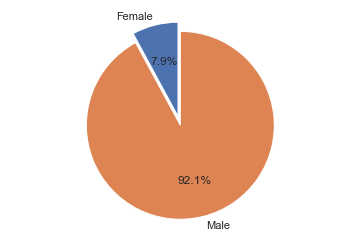

In [33]:
df_occup_gender_diag=df_all.groupby(['Year','Gender']).size().reset_index(name='Counts')
df_occup_gender_diag=df_occup_gender_diag.query('(Gender== "Male" or Gender=="Female") and (Year==2019)')

sizes=list(df_occup_gender_diag['Counts'].values)
labels=list(df_occup_gender_diag['Gender'].values)
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  

plt.show()

As noted earlier, in 2019 women make up only 8% of the male respondents.

Text(0, 0.5, 'Salary Midpoint')

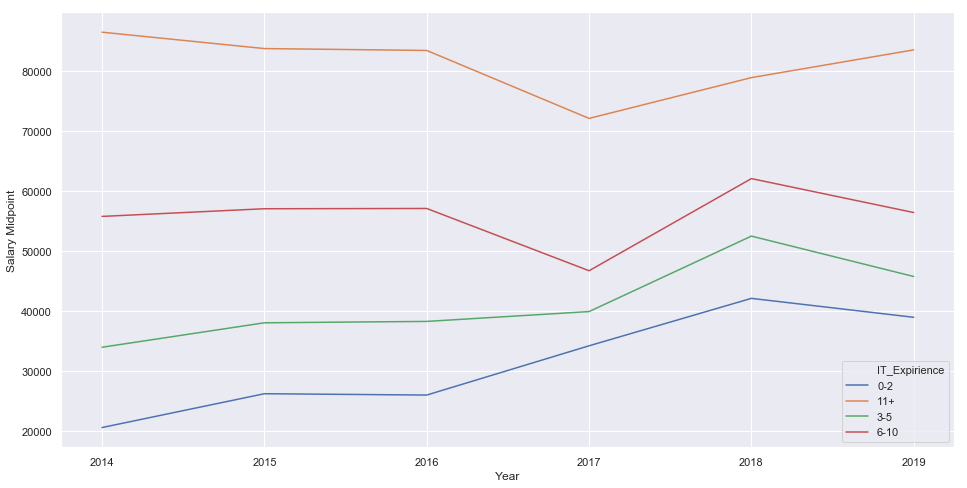

In [34]:
df_occup_salary=df_all.groupby(['Year','IT_Expirience'], as_index=False)['Salary Midpoint'].mean()
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 
ax = sns.lineplot(x="Year", y="Salary Midpoint", hue="IT_Expirience", data=df_occup_salary)
plt.xlabel("Year")
plt.ylabel("Salary Midpoint")

The schedule is completely objective: with the growth of experience, the salary grows. No anomalies are noticed.

In [35]:
df_plot=df_all[df_all['Year']==2019]
df_plot=df_plot.groupby(['Occupation','IT_Expirience']).size().reset_index(name='Counts')
df_plot=df_plot.pivot(index='IT_Expirience', columns='Occupation', values='Counts')

a1=df_plot.values[0]
a2=df_plot.values[1]
a3=df_plot.values[2]
a4=df_plot.values[3]

x = df_plot.columns

fig = go.Figure()
fig.add_trace(go.Bar(x=x, y=a1, name='Expirience 0-2'))
fig.add_trace(go.Bar(x=x, y=a3, name='Expirience 3-5'))
fig.add_trace(go.Bar(x=x, y=a4, name='Expirience 6-10'))
fig.add_trace(go.Bar(x=x, y=a2, name='Expirience 11+'))

fig.update_layout(barmode='relative', title_text='Expirience/Occupation-Year 2019')
fig.show()



From the graph we see that in 2019 the most popular areas are: back-end, full-stack, data-science and front-end. As we see, to work in these areas it is desirable to have 2-years experience.

In [36]:
df_plottt=df_all[df_all['Year']==2019]
df_plottt=df_plottt.groupby(['IT_Expirience','Education']).size().reset_index(name='Counts')
df_plottt=df_plottt.pivot(index='Education', columns='IT_Expirience', values='Counts')

def get_proc(x):
  x=np.array(x)
  lenght=np.sum(x)
  a=[]
  for i in x:
    i=i*100/lenght
    i=round(i,1)
    a.append(i)
  return a  



a1=df_plottt.values[0]
a2=df_plottt.values[1]
a3=df_plottt.values[2]
a4=df_plottt.values[3]
a5=df_plottt.values[4]
a6=df_plottt.values[5]
a7=df_plottt.values[6]
a8=df_plottt.values[7]

x_data=[a1,a2,a3,a4,a5,a6,a7,a8]
x_data=list(map(lambda x: get_proc(x) , x_data))
x_data

[[5.9, 40.1, 18.6, 35.4],
 [0.7, 86.5, 3.3, 9.5],
 [3.0, 58.2, 9.1, 29.7],
 [14.0, 32.0, 27.7, 26.2],
 [4.0, 38.4, 20.2, 37.4],
 [0.8, 81.8, 2.8, 14.6],
 [1.9, 56.4, 9.5, 32.1],
 [9.5, 42.9, 21.7, 25.9]]

In [37]:
top_labels = ['Expirience 0-2', 'Expirience 3-5', 'Expirience 6-10', 'Expirience 11+']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']



y_data = ['Bachelor in Computer Science',
          'Doctor in Computer Science',
          'Master in Computer Science', 'Online class', 
          'Online class + Bachelor in Computer Science',
          'Online class + Doctor in Computer Science', 'Online class + Master in Computer Science', 'Self-taught']

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=80),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):

    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))

    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(xd[0]) + '%',
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))

    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):

            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(xd[i]) + '%',
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))

            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations)

fig.show()

Now the IT market is dominated by people with 3-5 years of experience with varying degrees of education, as well as without education.

In [38]:
df_exp_age=df_all[df_all['Year']==2019]
df_exp_age=df_exp_age.groupby(['IT_Expirience','Age_range']).size().reset_index(name='Counts')
df_exp_age=df_exp_age.pivot(index='IT_Expirience', columns='Age_range', values='Counts')
df_exp_age


Age_range      20 - 24  25 - 34  35 - 44  45 - 60  < 20  > 60
IT_Expirience                                                
0-2               2148     1984      412      104  1242    24
11+                923    14308    11826     4901    95   653
3-5               6672     5969      709      139  2256    19
6-10              6949    14811     1372      188  1269    26

In [39]:
a1=df_exp_age.values[0]
a2=df_exp_age.values[1]
a3=df_exp_age.values[2]
a4=df_exp_age.values[3]

x_data=[a1,a2,a3,a4]
x_data=list(map(lambda x: get_proc(x) , x_data))
x_data

[[36.3, 33.5, 7.0, 1.8, 21.0, 0.4],
 [2.8, 43.7, 36.2, 15.0, 0.3, 2.0],
 [42.3, 37.9, 4.5, 0.9, 14.3, 0.1],
 [28.2, 60.2, 5.6, 0.8, 5.2, 0.1]]

In [40]:
labels = ["20 - 24", "25 - 34", "35 - 44", "45 - 60", "< 20", "> 60"]

fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=x_data[0], name="0-2"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=x_data[1], name="11+"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=x_data[2], name="3-5"),
              1, 3)
fig.add_trace(go.Pie(labels=labels, values=x_data[3], name="6-10"),
              1, 4)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Expirience/Age",
    annotations=[dict(text='IT Expirience 0-2', x=0.0, y=1.0, font_size=20, showarrow=False),
                 dict(text='IT Expirience 11+', x=0.25, y=1.0, font_size=20, showarrow=False),
                dict(text='IT Expirience 3-5', x=0.6, y=1.0, font_size=20, showarrow=False),
                dict(text='IT Expirience 6-10', x=0.95, y=1.0, font_size=20, showarrow=False)])
fig.show()

A small number of people over 40 in IT. The main number - age from 25 to 34.

In [41]:
df_age_educ=df_all.copy()  
df_age_educ=df_age_educ[df_age_educ['Year']==2019]
df_age_educ['Education']=df_age_educ['Education'].apply(lambda x:get_educ(x))
df_age_educ=df_age_educ.groupby(['Education','Age_range']).size().reset_index(name='counts')
df_age_educ=df_age_educ.pivot(index='Education', columns='Age_range', values='counts')
df_age_educ


Age_range                     20 - 24  25 - 34  35 - 44  45 - 60  < 20  > 60
Education                                                                   
Bachelor in Computer Science     7854    15468     4640     1377   275   128
Doctor in Computer Science         10      396      430      162     6    49
Master in Computer Science       1144     8146     3312      982    28   112
Not Educated                     6421    11351     5223     2488  3994   383

In [42]:
a1=df_age_educ.values[0]
a2=df_age_educ.values[1]
a3=df_age_educ.values[2]
a4=df_age_educ.values[3]

x_data=[a1,a2,a3,a4]
x_data=list(map(lambda x: get_proc(x) , x_data))
x_data

[[26.4, 52.0, 15.6, 4.6, 0.9, 0.4],
 [0.9, 37.6, 40.8, 15.4, 0.6, 4.7],
 [8.3, 59.4, 24.1, 7.2, 0.2, 0.8],
 [21.5, 38.0, 17.5, 8.3, 13.4, 1.3]]

In [43]:
labels = ["20 - 24", "25 - 34", "35 - 44", "45 - 60", "< 20", "> 60"]

fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=x_data[0], name="Bachelor"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=x_data[1], name="Doctor"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=x_data[2], name="Master"),
              1, 3)
fig.add_trace(go.Pie(labels=labels, values=x_data[3], name="Not Educated"),
              1, 4)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Education/Age",
    annotations=[dict(text='Bachelor in Computer Science', x=0.0, y=1.1, font_size=17, showarrow=False),
                 dict(text='Doctor in Computer Science', x=0.25, y=1.0, font_size=17, showarrow=False),
                dict(text='Master in Computer Science', x=0.6, y=1.1, font_size=17, showarrow=False),
                dict(text='Not Educated', x=0.95, y=1.0, font_size=17, showarrow=False)])
fig.show()

Text(0, 0.5, 'Counts')

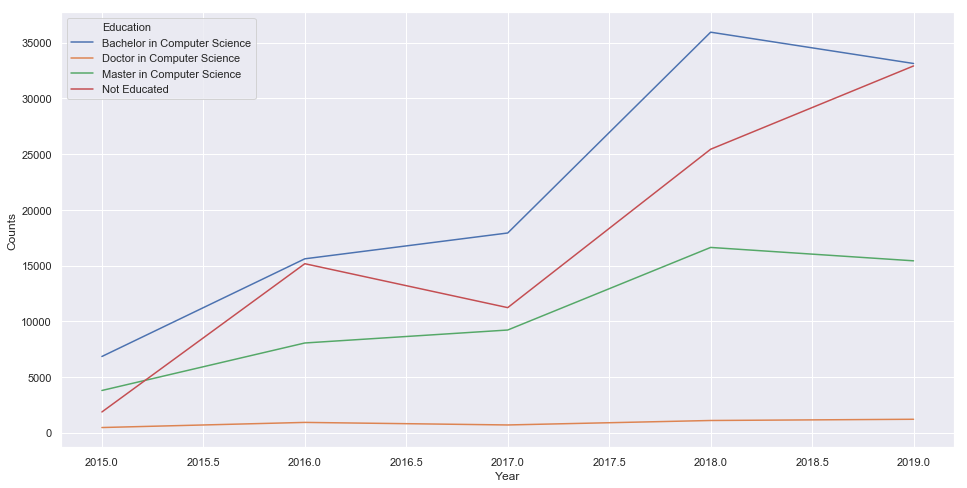

In [44]:
df_1=df_all.copy()  
df_1['Education']=df_1['Education'].apply(lambda x:get_educ(x))
df_1=df_1.groupby(['Education','Year']).size().reset_index(name='counts')
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 
ax = sns.lineplot(x="Year", y="counts", hue="Education", data=df_1)
plt.xlabel("Year")
plt.ylabel("Counts")

By 2019, the number of bachelors and people without education has become equal and occupies a leading position.

In [57]:
df_all.to_csv('pp.csv')
sf = SFrame.read_csv(url='pp.csv',verbose=False )
sf=sf[sf['Year']>2013]
sf_skills=sf.stack('Skills', new_column_name='Skills')
dd=sf_skills.to_dataframe()
sf_ide=sf.stack('IDE', new_column_name='IDE')
df_ide=sf_ide.to_dataframe()
dd




X1   Age                   Country  \
0        347689  18.0                     Spain   
1        347689  18.0                     Spain   
2        347689  18.0                     Spain   
3        347689  18.0                     Spain   
4        347689  18.0                     Spain   
5        347689  18.0                     Spain   
6        347689  18.0                     Spain   
7        347689  18.0                     Spain   
8        347689  18.0                     Spain   
9        347689  18.0                     Spain   
10       347689  18.0                     Spain   
11       347689  18.0                     Spain   
12       347689  18.0                     Spain   
13       347689  18.0                     Spain   
14       347689  18.0                     Spain   
15       347689  18.0                     Spain   
16       288437  23.0                  Pakistan   
17       288437  23.0                  Pakistan   
18       288437  23.0                  Pakistan   
19       288437  23.0                  Pakistan   
20       288437  23.0                  Pakistan   
21       288437  23.0                  Pakistan   
22       288437  23.0                  Pakistan   
23       288437  23.0                  Pakistan   
24       288437  23.0                  Pakistan   
25       288429  24.0                     India   
26       288429  24.0                     India   
27       288429  24.0                     India   
28       288429  24.0                     India   
29       288429  24.0                     India   
...         ...   ...                       ...   
2221449   23653  20.0                Costa Rica   
2221450   23653  20.0                Costa Rica   
2221451   23653  20.0                Costa Rica   
2221452   23666   NaN  United States of America   
2221453   23657   NaN  United States of America   
2221454   23661  20.0  United States of America   
2221455   23978   NaN                    Sweden   
2221456   23984   NaN                    Canada   
2221457   23952  35.0  United States of America   
2221458   23952  35.0  United States of America   
2221459   23952  35.0  United States of America   
2221460   23952  35.0  United States of America   
2221461   23952  35.0  United States of America   
2221462   23956  25.0  United States of America   
2221463   24036   NaN               Switzerland   
2221464   24047  20.0                     Spain   
2221465   24025  20.0                    France   
2221466   24015   NaN                    Israel   
2221467   23858   NaN                    Canada   
2221468   23875   NaN                   Hungary   
2221469   23914  30.0                    Canada   
2221470   23914  30.0                    Canada   
2221471   23914  30.0                    Canada   
2221472   23914  30.0                    Canada   
2221473   23914  30.0                    Canada   
2221474   23892  25.0  United States of America   
2221475   23884   NaN  United States of America   
2221476   23885   NaN  United States of America   
2221477   23897   NaN                    Serbia   
2221478   23894   NaN                      Peru   

                                         Education                  Gender  \
0        Online class + Master in Computer Science                    Male   
1        Online class + Master in Computer Science                    Male   
2        Online class + Master in Computer Science                    Male   
3        Online class + Master in Computer Science                    Male   
4        Online class + Master in Computer Science                    Male   
5        Online class + Master in Computer Science                    Male   
6        Online class + Master in Computer Science                    Male   
7        Online class + Master in Computer Science                    Male   
8        Online class + Master in Computer Science                    Male   
9        Online class + Master in Computer Science                    

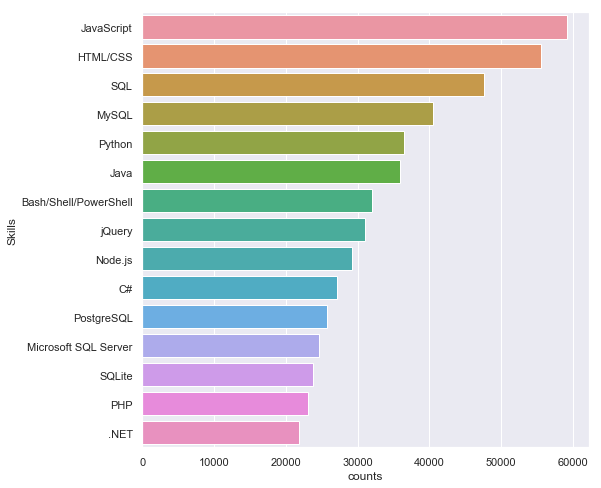

In [58]:
dd['Skills']=dd['Skills'].str.strip() 
dd1=dd[dd['Year']==2019]
dd1=dd1.groupby(['Skills']).size().reset_index(name='counts')
dd1=dd1.sort_values(by=['counts'], ascending=False)
dd2=dd.groupby(['Skills','Year']).size().reset_index(name='counts')
dd1=dd1[:15]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='Skills', x='counts',orient="h", data=dd1, ax=ax)

We have compiled a list of the top 15 languages and technologies and reviewed their popularity over time.

Text(0, 0.5, 'Counts')

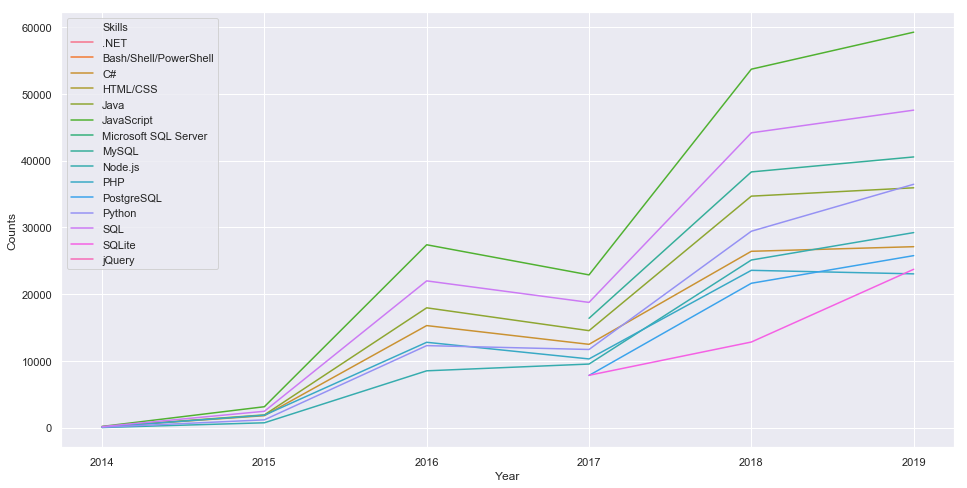

In [59]:
top10=dd1['Skills'].array[:15]
df_filter = dd2['Skills'].isin(top10)
df_top10=dd2[df_filter]
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 
ax = sns.lineplot(x="Year", y="counts", hue="Skills", data=df_top10)
plt.xlabel("Year")
plt.ylabel("Counts")

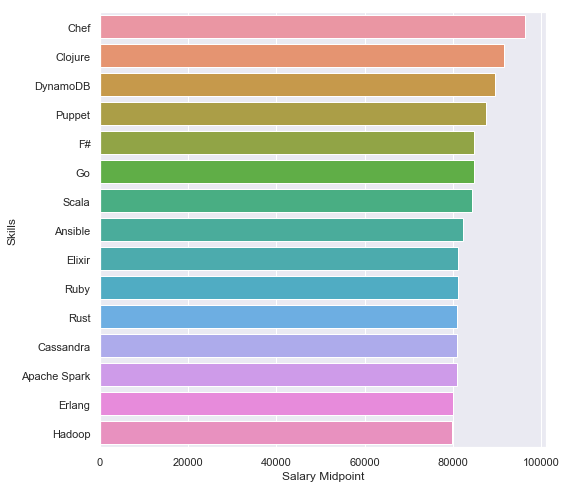

In [60]:
dd1=dd[dd['Year']==2019]
dd1=dd1.groupby(['Skills'], as_index=False)['Salary Midpoint'].mean()
dd1=dd1.sort_values(by=['Salary Midpoint'], ascending=False)
dd2=dd.groupby(['Skills','Year'], as_index=False)['Salary Midpoint'].mean()
dd1=dd1[:15]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='Skills', x='Salary Midpoint',orient="h", data=dd1, ax=ax)

We have compiled a list of the top 15 languages and technologies by wages and analyzed by time.
In 2019, languages and technologies that allow working with Big Data are great value.

Text(0, 0.5, 'Counts')

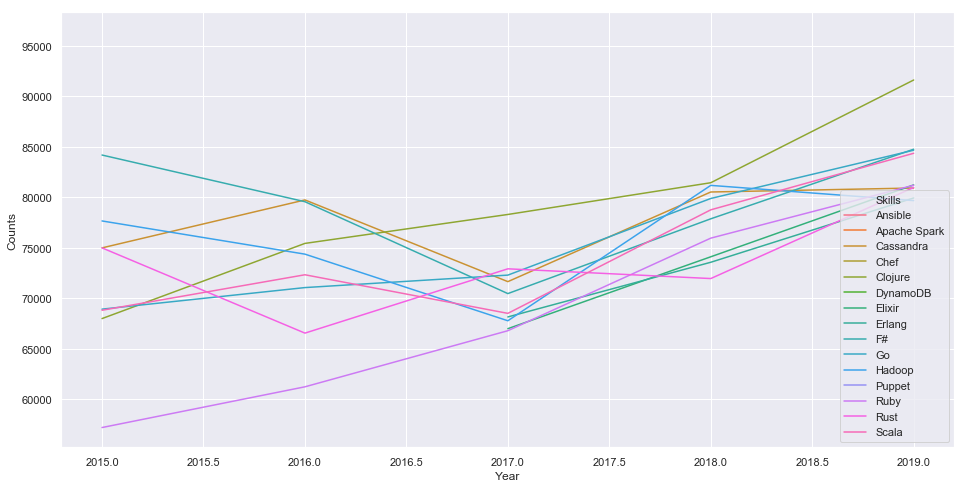

In [61]:
top10=dd1['Skills'].array[:15]
df_filter = dd2['Skills'].isin(top10)
df_top10=dd2[df_filter]
sns.set()
plt.figure(figsize = (16, 8), facecolor = None) 
ax = sns.lineplot(x="Year", y="Salary Midpoint", hue="Skills", data=df_top10)
plt.xlabel("Year")
plt.ylabel("Counts")

In [62]:
df_plotly=dd[dd['Year']==2019]
df_plotly=df_plotly[['Salary Midpoint','Occupation','Skills']].dropna()
df_plotly=df_plotly.groupby(['Occupation','Skills'], as_index=False).agg({'Salary Midpoint': ['mean','size']})
df_plotly.columns=['Occupation','Skills','Salary mean','Count']
px.scatter(df_plotly, x="Occupation", y="Salary mean", color="Skills", size='Count', size_max=50,width=1200,height=600)

We considered which languages and technologies  use people of different professions. And the dependence of the wages of employees of these professions on the knowledge of a particular language.

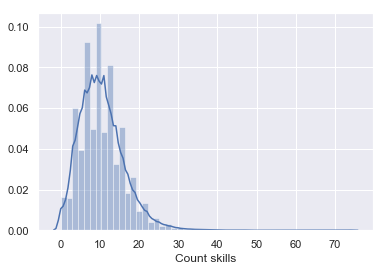

In [63]:
def counter(x):
  if isinstance(x,list):
    return int(len(x))
  if isinstance(x,str):
    return int(1)
  else:
    return None

df_all1=df_all[df_all['Year']==2019]
df_all1['Count skills']=df_all1['Skills'].dropna()
df_all1['Count skills']=df_all1['Count skills'].apply(lambda x:counter(x))
x=df_all1['Count skills']
sns.distplot(x);

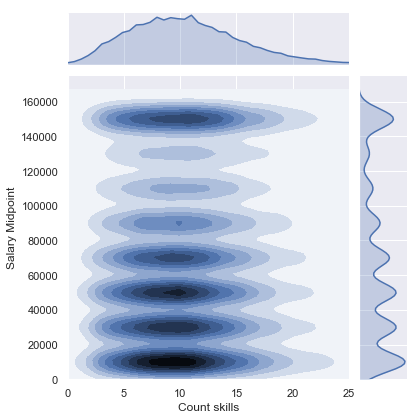

In [64]:
df_all1=df_all[df_all['Year']==2019]
df_all1=df_all1[['Skills','Salary Midpoint']].dropna()
df_all1['Count skills']=df_all1['Skills'].apply(lambda x:counter(x))
x=df_all1['Count skills']
y=df_all1['Salary Midpoint']
sns.jointplot(x, y, kind="kde", xlim=(0,25), ylim=(0,175000))



In each segment of salaries, it is necessary and sufficient to own 8-10 languages / technologies.

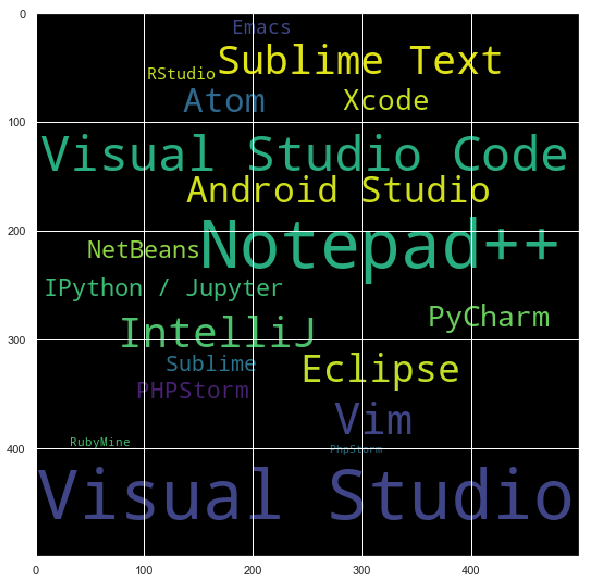

In [65]:
wordcloud = WordCloud(width = 500, height = 500, 
                    background_color ='black',  
                    min_font_size = 10)

df_ide1=df_ide['IDE'].dropna().str.strip()
c = Counter(list(df_ide1.values))
wordcloud.generate_from_frequencies(frequencies=c)
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud)


We made an IDE frequency tag cloud for fun.

**Conclusions**



1.   If there is no academic degree, then online education in IT is a good alternative.
2.   In terms of salary, it makes no sense to get a master's degree without the intention to get PhD.
3.   Ph.D-degree guarantees high salary.
4.   For successful employment it is necessary to have experience of at least 2 years.
5.   It is necessary and sufficient to own 8-9 technologies / languages.
6.   The main areas of interest in 2019 are: Back-end, Front-end, Full-stack and Data science. Of these, on Data science, the average wage is higher than in the remaining three areas.
7.   The most financially valued technologies / languages that are related to Big Data.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive")
os.getcwd() 
!pip install turicreate
!pip install plotly_express
# !pip install pycountry

In [ ]:
del os.environ['LC_ALL']